# Incremental Evaluation

## 1 - Load the data

In [1]:
# Imports

import json
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_curve

import matplotlib.pyplot as plt


from compare import *

# Set this to the path where the data is 
DATA_ROOT = 'C:\openmic-2018\openmic-2018'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')


In [2]:
# Loading the data
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)

# Make direct variable names for everything
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']


In [3]:
# Map class indices to names
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [4]:
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

## 2 - Load the splits
### Creating splits for train, test, and the unlabeled data.
###### Adapted from the original OpenMIC notebook

In [5]:
# Split the data into train, test, and unlabeled sets
# Use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'), 
                          header=None).squeeze("columns")
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), 
                         header=None).squeeze("columns")

# Create partition CSV for unlabeled
split_unlabeled = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_unlabeled.csv'), 
                         header=None).squeeze("columns")

In [6]:
# The breakdown of the data is roughly 50% training, 25% test, 25% unlabeled
# The percentage breakdowns can be adjusted by adjusting the partitions csv's above 
print('# Train: {},  # Test: {}, # Unlabeled: {}'.format(len(split_train), len(split_test), len(split_unlabeled)))

# Train: 9993,  # Test: 5085, # Unlabeled: 4922


In [7]:
train_set = set(split_train)
test_set = set(split_test)
unlabeled_set = set(split_unlabeled)

In [8]:
# Split the data into arrays

idx_train, idx_test, idx_unlabeled = [], [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    elif n in unlabeled_set:
        idx_unlabeled.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)
idx_unlabeled = np.asarray(idx_unlabeled)

### What's included in the data?

- `X`: 20000 * 10 * 128 array of VGGish features
    - First index (0..19999) corresponds to the sample key
    - Second index (0..9) corresponds to the time within the clip (each time slice is 960 ms long)
    - Third index (0..127) corresponds to the VGGish features at each point in the 10sec clip
    - Example `X[40, 8]` is the 128-dimensional feature vector for the 9th time slice in the 41st example
- `Y_true`: 20000 * 20 array of *true* label probabilities
    - First index corresponds to sample key, as above
    - Second index corresponds to the label class (accordion, ..., voice)
    - Example: `Y[40, 4]` indicates the confidence that example #41 contains the 5th instrument
- `Y_mask`: 20000 * 20 binary mask values
    - First index corresponds to sample key
    - Second index corresponds to the label class
    - Example: `Y[40, 4]` indicates whether or not we have observations for the 5th instrument for example #41
- `sample_key`: 20000 array of sample key strings
    - Example: `sample_key[40]` is the sample key for example #41

In [9]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = X[idx_train]
X_test = X[idx_test]
X_unlabeled = X[idx_unlabeled]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]
Y_true_unlabeled = Y_true[idx_unlabeled]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]
Y_mask_unlabeled = Y_mask[idx_unlabeled]

In [10]:
# Validate shapes of slices
print(X_train.shape)
print(X_test.shape)
print(X_unlabeled.shape)

(9993, 10, 128)
(5085, 10, 128)
(4922, 10, 128)


## 3 - Fit the models

In [11]:
models = dict()

for instrument in class_map:

    # Map the instrument name to its column number
    inst_num = class_map[instrument]

    rfc = trainModel("rfc",inst_num, X_train, Y_true_train, Y_mask_train)[0]
    knn = trainModel("knn",inst_num, X_train, Y_true_train, Y_mask_train)[0]
   
    # Store the classifier in our dictionary
    models[instrument] = [rfc, knn]

## 4 - Algorithmic Disagreement

#### In the algorithimc disagreement process, two models evaluate the same piece of data and their evaluations are compared. If they disagree on their evaluation, that track is deemed to be a priority for annotation.
##### Let's start with an example

In [12]:
# We need soundfile to load audio data
import soundfile as sf

# For audio playback
from IPython.display import Audio

In [13]:
# Run algorithmic disagreement process

# Populate skipIndices with empty arrays to be filled
skipIndices = {}
for i in class_map:
    skipIndices[i] = []


# uncertaintyScores, allPredictions = compare(X_unlabeled, models, skipIndices=skipIndices)

In [14]:
# uncertaintyScores["voice"]

In [15]:
# list(uncertaintyScores["voice"].items())[:5]

In [16]:
# Get ID of the most uncertain track for voice
# highest_idx = list(uncertaintyScores.get("voice").items())[0][0]
# trackID = split_unlabeled[highest_idx]

In [17]:
# And the most uncertain track is...
# trackID

Let's hear what this difficult-to-label track sounds like!

In [18]:
# Replace below .ogg file with trackID
# audio, rate = sf.read(os.path.join(DATA_ROOT, 'audio/027/027639_257280.ogg'))

In [19]:
# Let's listen to the example
# Audio(data=audio.T, rate=rate)

### 5 - Incremental Evaluation -- Simulate the Annotation Process

In [20]:
# First, train a model on the fully annotated dataset. This is what we will be measuring efficiency against. 
combined_models = dict()
ctrl_true_vals = dict()

for instrument in class_map:

    # get column num from instrument name
    inst_num = class_map[instrument]

    rfc, props = trainModel("rfc",inst_num, X_train, Y_true_train, Y_mask_train)
    combined_models[instrument] = rfc

    # Repeat slicing for test
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5


    ctrl_true_vals[instrument] = Y_true_test_inst


In [21]:
# Constants
NUM_TO_LABEL = 500  # Batch size
EPOCHS = 5       # Number of times to annotate

# NUM_RANDOM = 50      # Number of random tracks to include 

# Set Up
skipIndices = {}
accuracies_over_time = {}
ctrl_accuracies = {}
instrProps = {}
reports = {}
f1s = {}
# Populate dictionaries with instrument keys
for i in class_map:
    skipIndices[i] = []
    accuracies_over_time[i] = []
    ctrl_accuracies[i] = []
    instrProps[i] = []
    reports[i] = []
    f1s[i] = []

X_labeled = []           # Track IDs for labeled tracks
Y_true_labeled = []      # True values for labeled tracks

# MAIN LOOP
for i in range(EPOCHS):

    # get instrument predictions
    sorted_trx, allInstProbs = compare(X_unlabeled, models, skipIndices=skipIndices)

    for instr in sorted_trx:    

        ###########################################################################
        # SELECT TRACKS FOR ANNOTATION

        # Retrieve the top tracks for annotation
        track_indices = list(sorted_trx[instr].items())[:NUM_TO_LABEL]
        track_indices = [i[0] for i in track_indices]   # isolates the indices

        # add random tracks to be annotated to avoid false positives
        # track_indices = addRandomTracks(NUM_RANDOM, len(sorted_trx[instr]), track_indices, allInstProbs[instr])

        # add track IDs to the labeled list
        for trk in track_indices:
            X_labeled.append(X_unlabeled[trk])

            # If the track has not yet been labeled for this instrument, update with avg prediction
            if Y_true_unlabeled[trk][class_map[instr]] == 0.5:
                Y_true_unlabeled[trk][class_map[instr]] = np.average(allInstProbs[instr][trk])
        
            Y_true_labeled.append(Y_true_unlabeled[trk])
            Y_mask_unlabeled[trk][class_map[instr]] = True

        # Update indices to skip here
        skipIndices[instr] = np.append(skipIndices[instr], track_indices)

        ###########################################################################
        # TRAIN MODEL ON PARTIALLY ANNOTATED DATASET
        
        inst_num = class_map[instr]
        model, props = trainModel(modelType="rfc",inst_num=inst_num, X_train=X_train, \
                X_labeled=X_labeled, Y_true_train=Y_true_train, Y_true_labeled=np.array(Y_true_labeled), \
                Y_mask_train=Y_mask_train)
        
        instrProps[instr].append(props)

        # Repeat slicing for test
        test_inst = Y_mask_test[:, inst_num]
        X_test_inst = X_test[test_inst]
        X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
        Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

        ###########################################################################
        # COMPARE ACCURACY WITH FULLY ANNOTATED MODEL

        # Graph the accuracy results
        control_model = combined_models[instr]

        Y_pred_test_ctrl = control_model.predict(X_test_inst_sklearn)
        Y_pred_test_rfc = model.predict(X_test_inst_sklearn)

        rprt = classification_report(Y_true_test_inst, Y_pred_test_rfc, output_dict=True) 
        ctrl_rprt = classification_report(ctrl_true_vals[instr], Y_pred_test_ctrl, output_dict=True)

        acc = rprt["accuracy"]
        ctrl_acc = ctrl_rprt["accuracy"]


        f1 = rprt['weighted avg']['f1-score']

        accuracies_over_time[instr].append(acc)
        ctrl_accuracies[instr].append(ctrl_acc)
        f1s[instr].append(f1)
        reports[instr].append(rprt)


accordion starting
banjo starting
bass starting
cello starting
clarinet starting
cymbals starting
drums starting
flute starting
guitar starting
mallet_percussion starting
mandolin starting
organ starting
piano starting
saxophone starting
synthesizer starting
trombone starting
trumpet starting
ukulele starting
violin starting
voice starting
0 Y true train new length (1203,) (1003,) 200
1 Y true train new length (1447,) (1047,) 400
2 Y true train new length (1535,) (935,) 600
3 Y true train new length (1847,) (1047,) 800
4 Y true train new length (2131,) (1131,) 1000
5 Y true train new length (2053,) (853,) 1200
6 Y true train new length (2241,) (841,) 1400
7 Y true train new length (2630,) (1030,) 1600
8 Y true train new length (2641,) (841,) 1800
9 Y true train new length (2971,) (971,) 2000
10 Y true train new length (3380,) (1180,) 2200
11 Y true train new length (3465,) (1065,) 2400
12 Y true train new length (3493,) (893,) 2600
13 Y true train new length (3943,) (1143,) 2800
14 Y t

# Graph the results

In [25]:
# for i in class_map:

#     # plt.figure(figsize=(6,6))

#     plt.bar(["train positive", "train negative"], height=instrProps[i][j].get('train'))
#     plt.bar(["test positive", "test negative"], height=instrProps[i][j].get('test'))

#     plt.xlabel("Epochs")
#     plt.ylabel("Number of Tracks")
#     plt.title(i)
#     plt.show()

In [26]:
# x = np.arange(len(class_map))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained', figsize=(12,4))

# for train in instrProps[i][0].items():
#     val = train
#     offset = width * multiplier
#     rects = ax.bar(x + offset, train[1][0], width, label=train[0])
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Number of Tracks')
# ax.set_title('Positive vs. Negative Examples')
# ax.set_xticks(x + width, class_map)
# ax.legend(loc='upper left', ncols=3)

# plt.show()

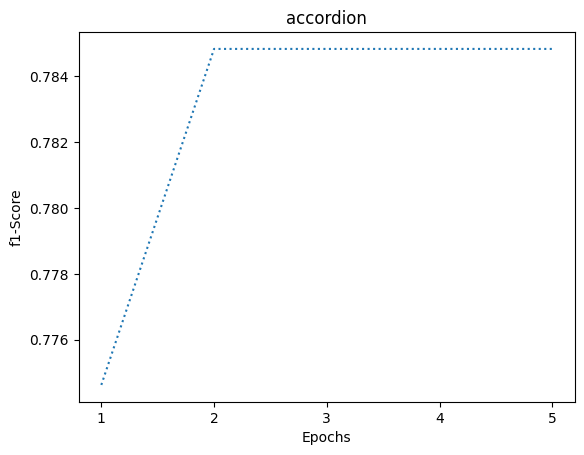

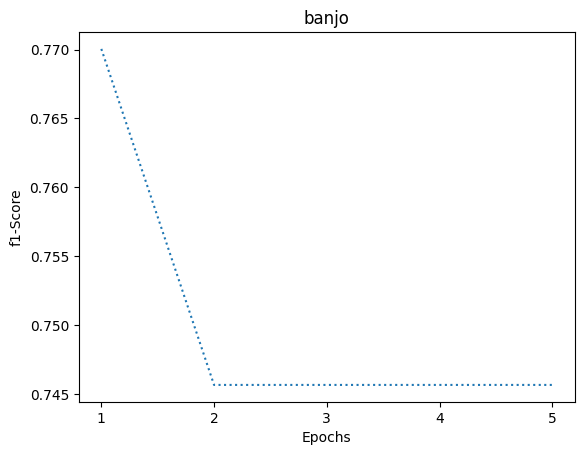

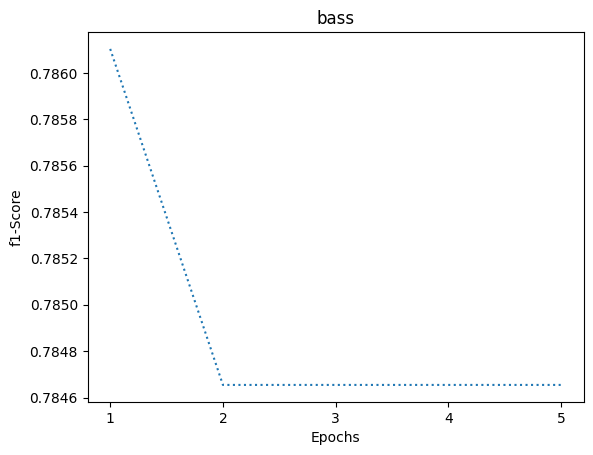

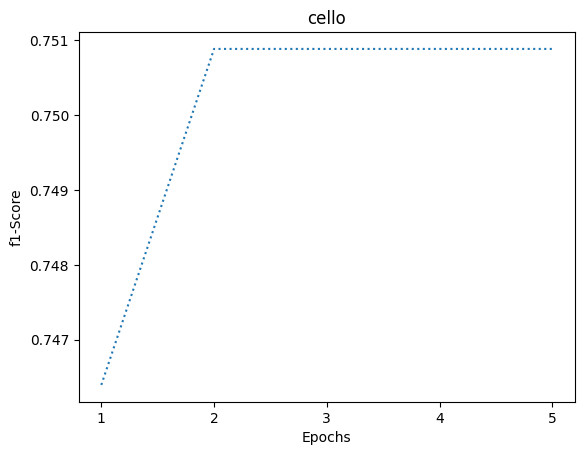

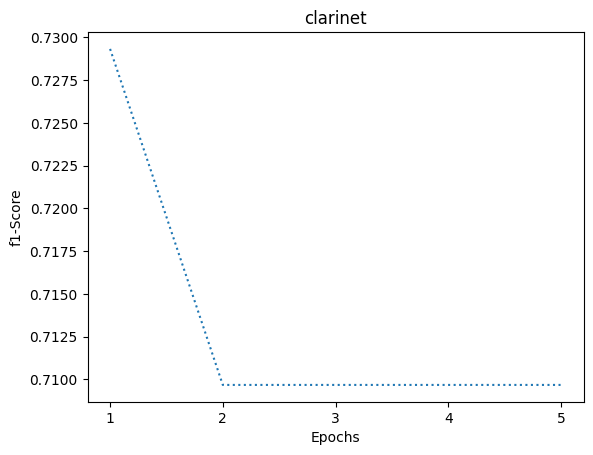

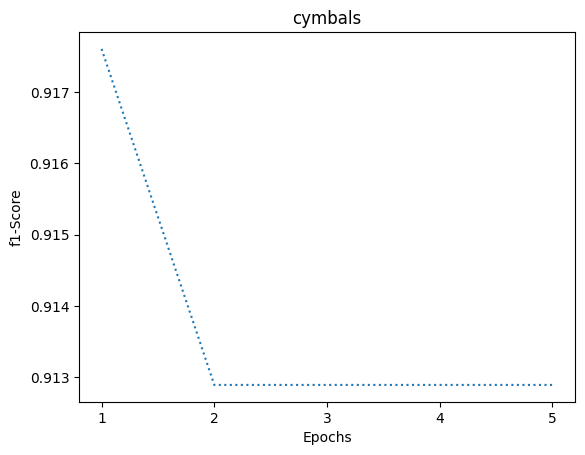

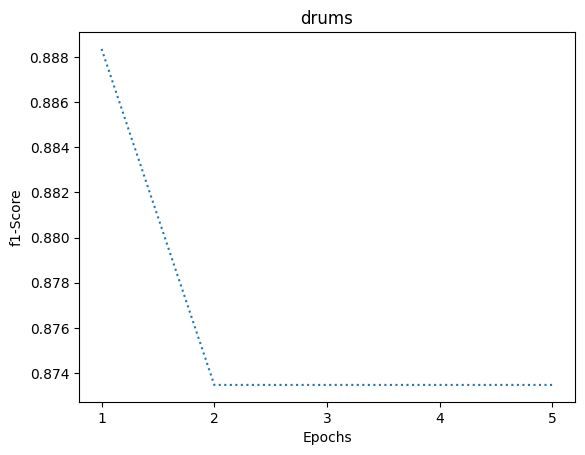

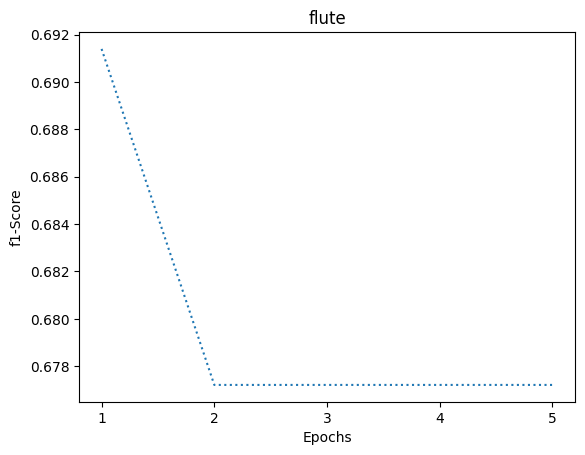

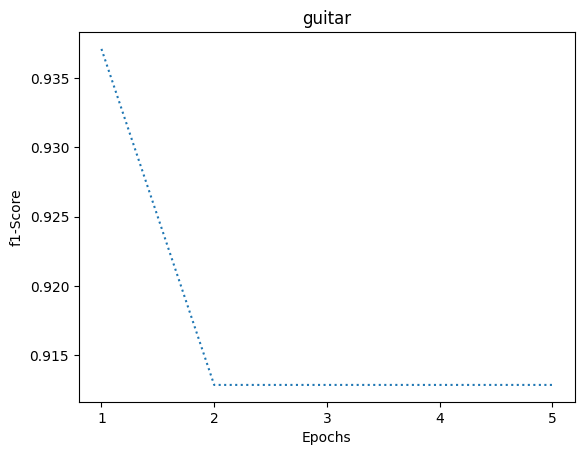

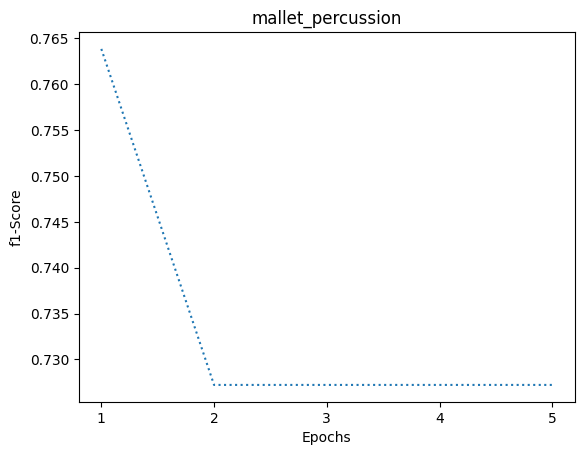

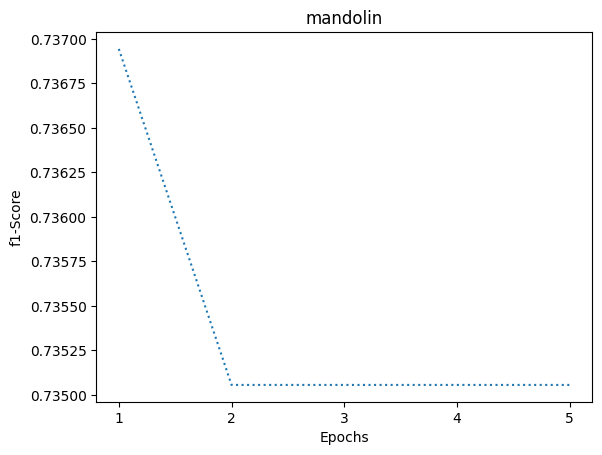

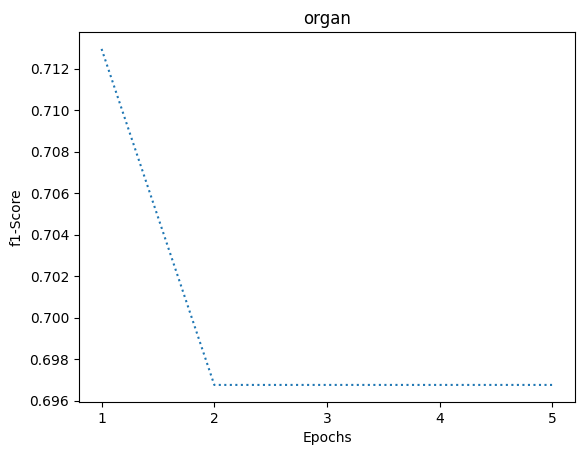

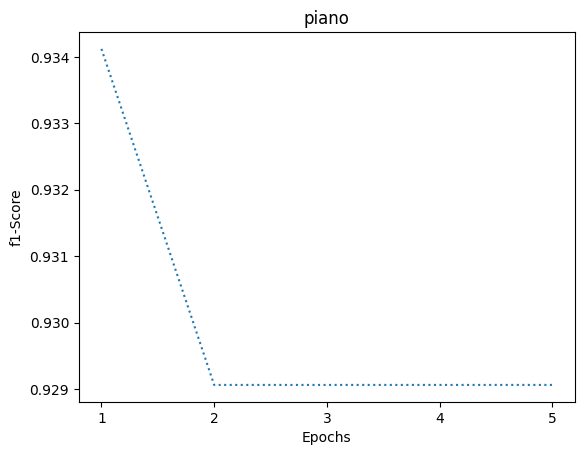

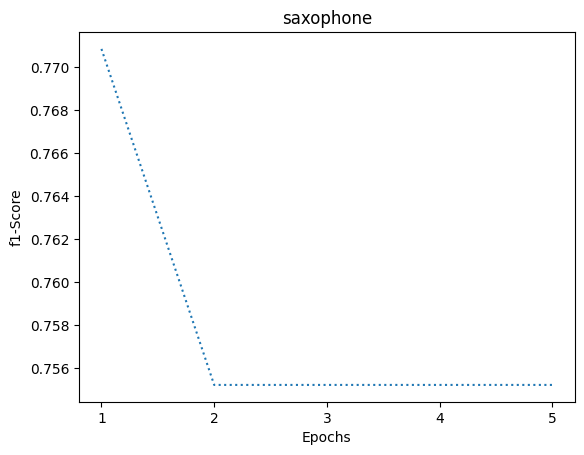

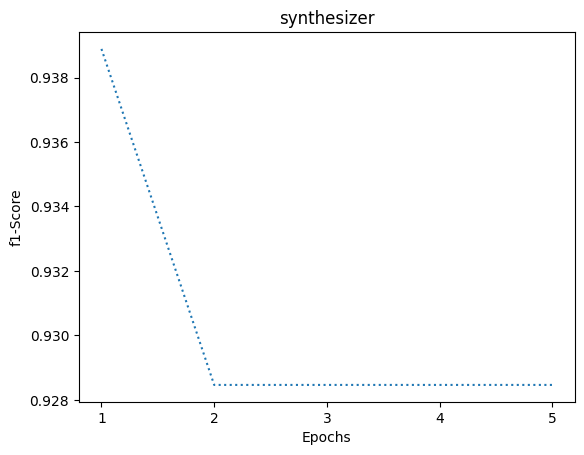

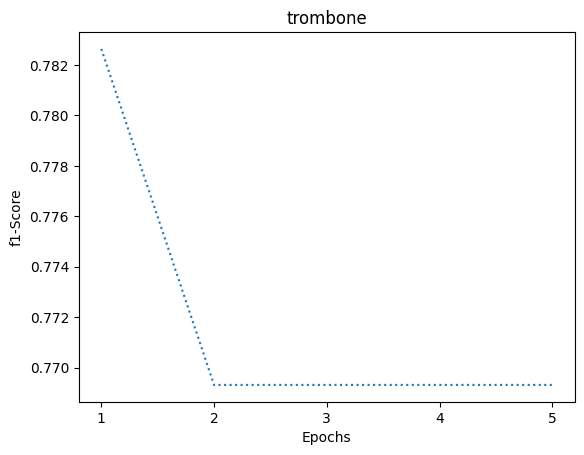

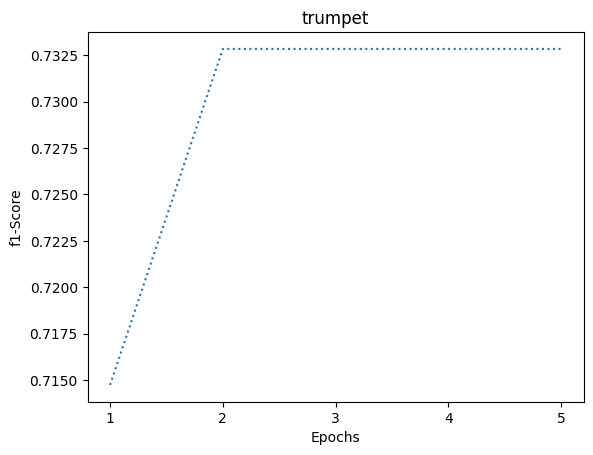

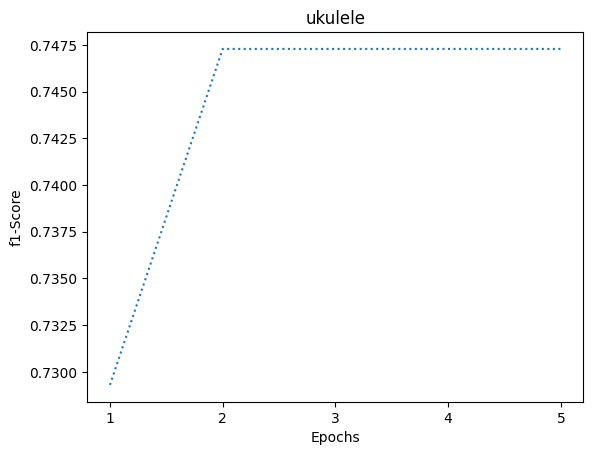

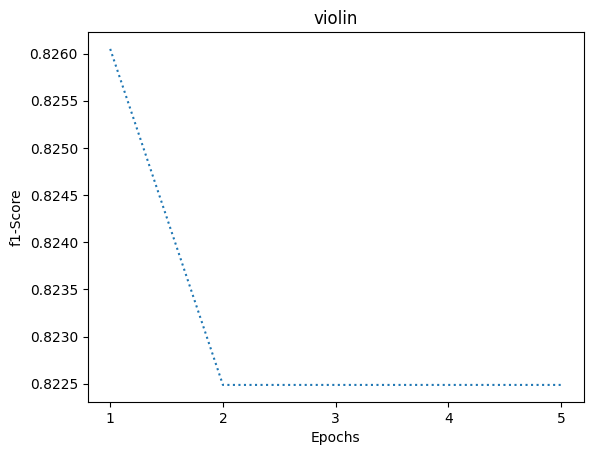

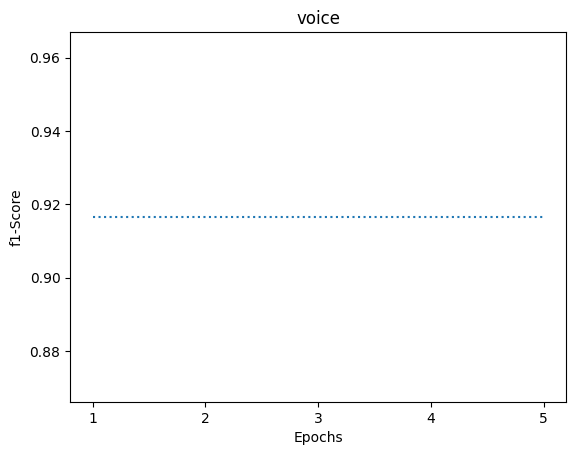

In [27]:
for i in class_map:
    plt.plot(f1s[i], linestyle='dotted')
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(f1s[i])), np.arange(1, len(f1s[i])+1))
    plt.ylabel("f1-Score")
    plt.title(i)
    plt.show()

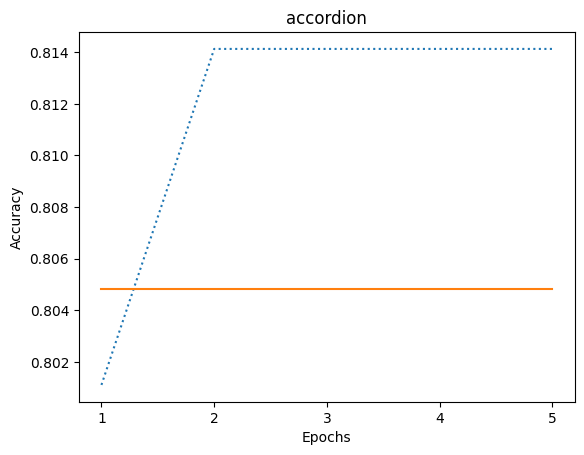

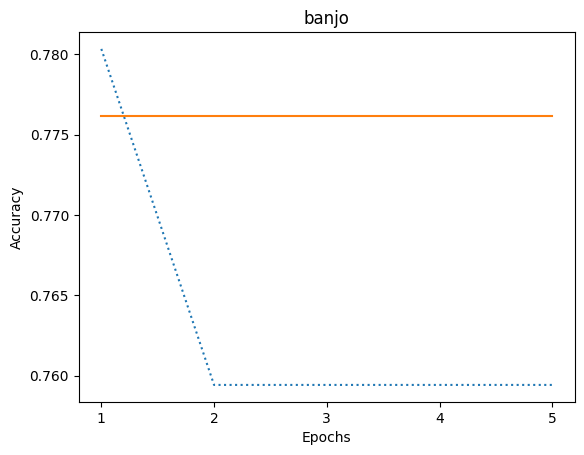

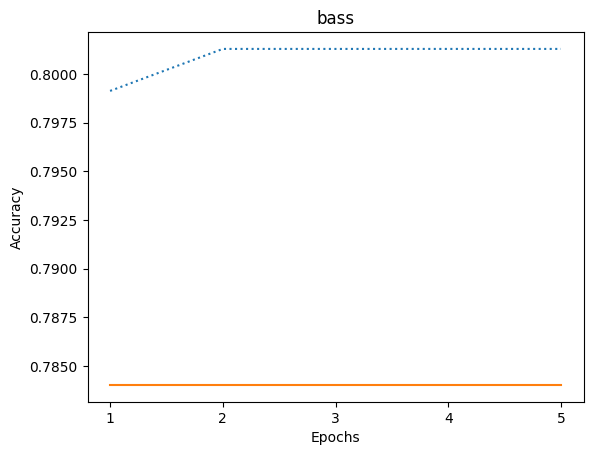

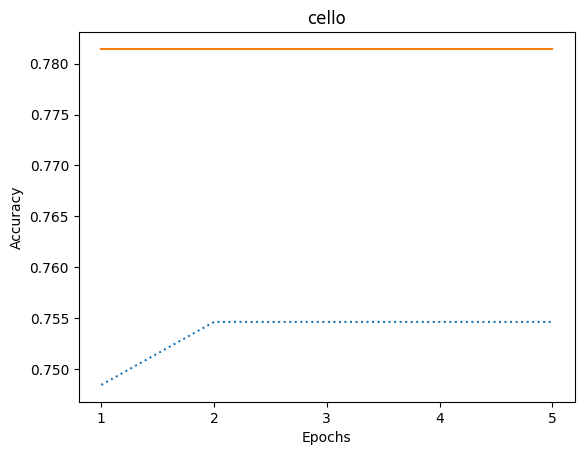

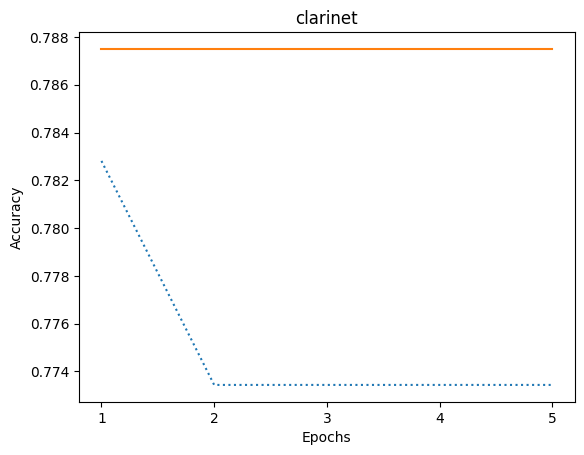

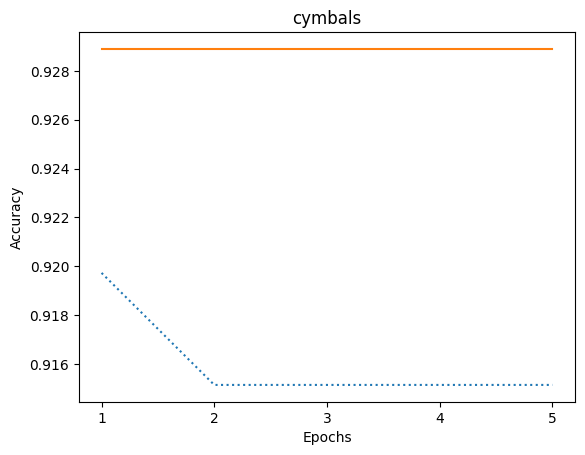

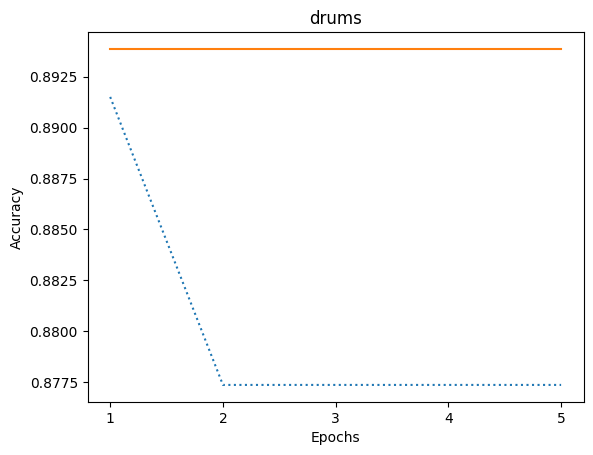

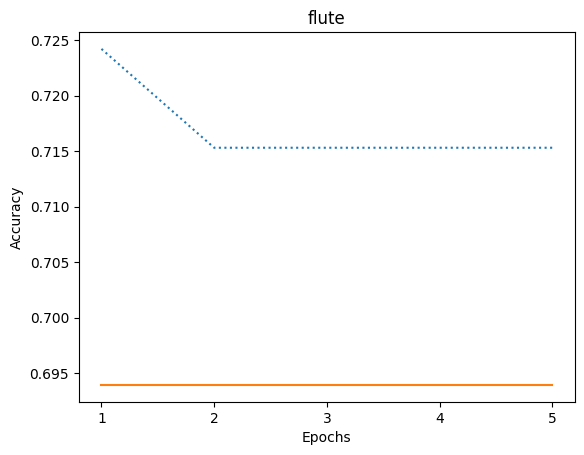

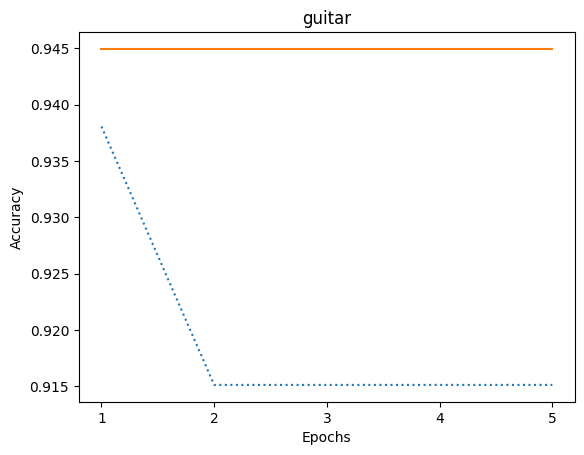

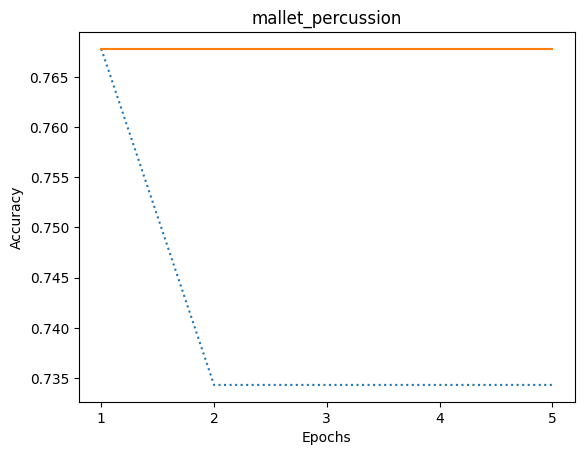

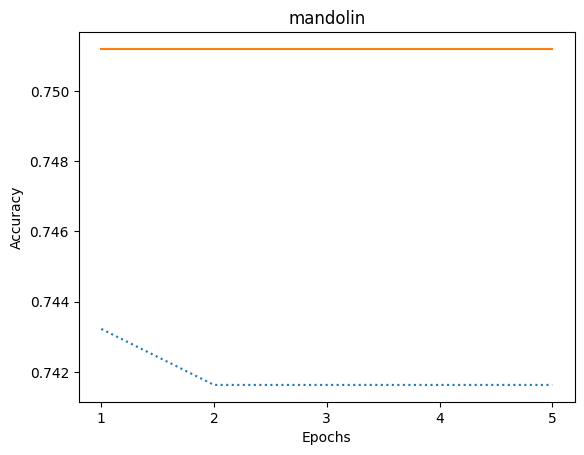

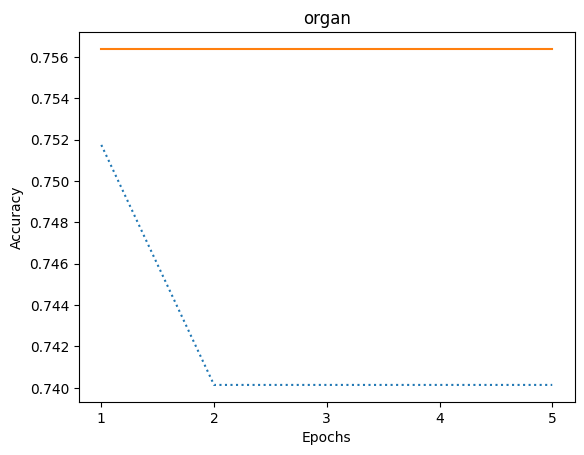

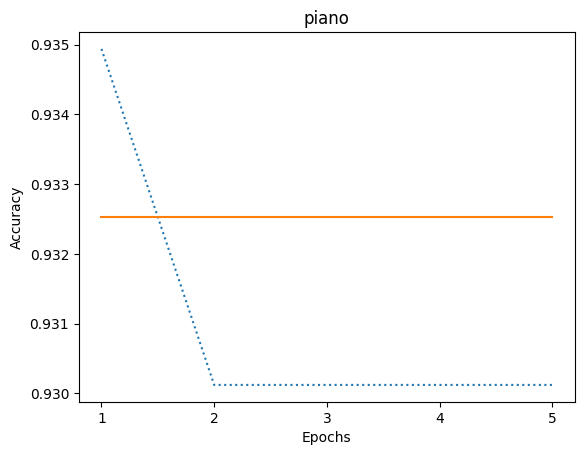

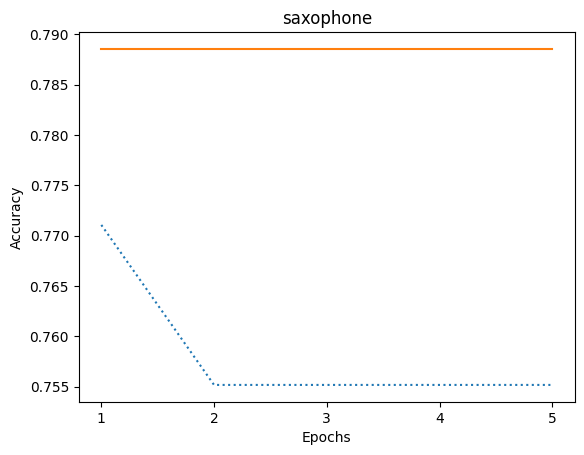

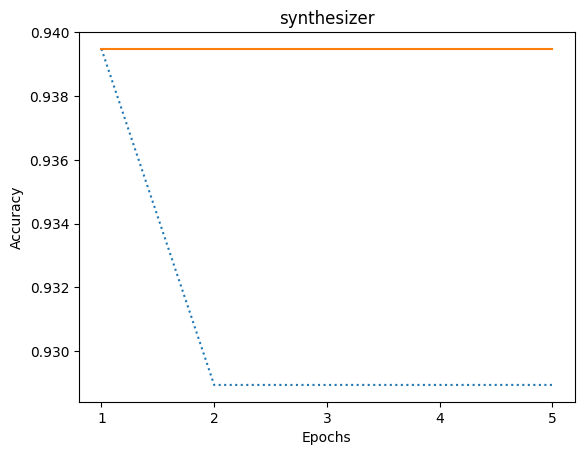

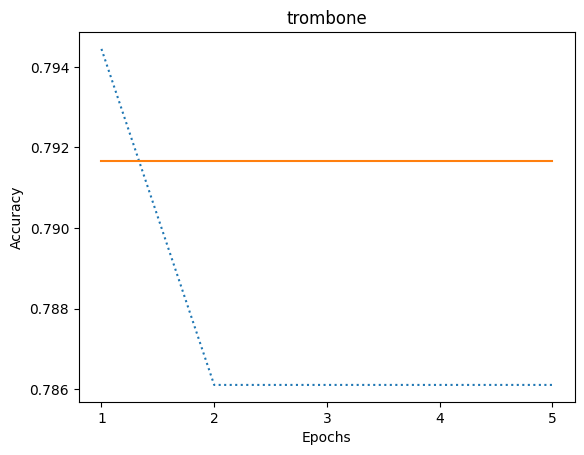

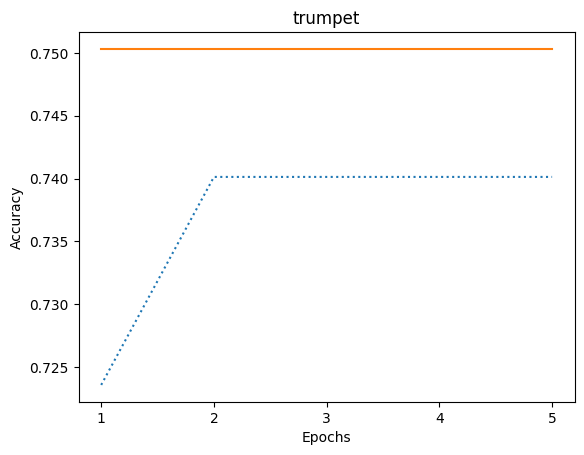

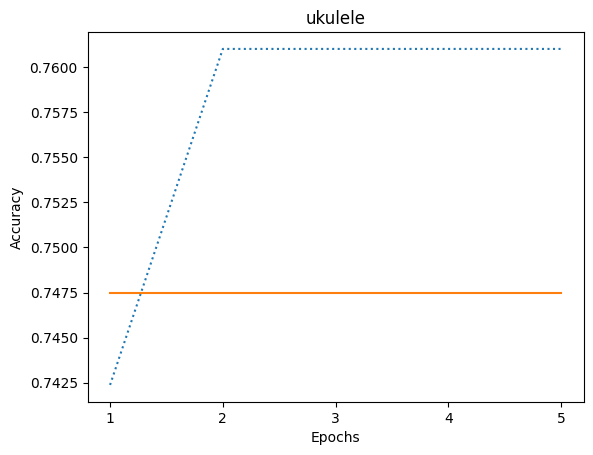

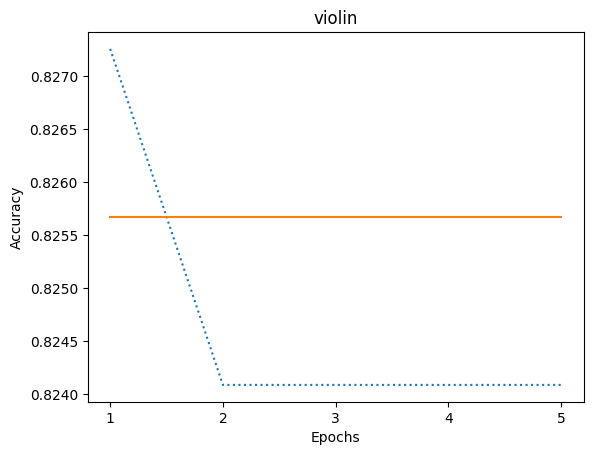

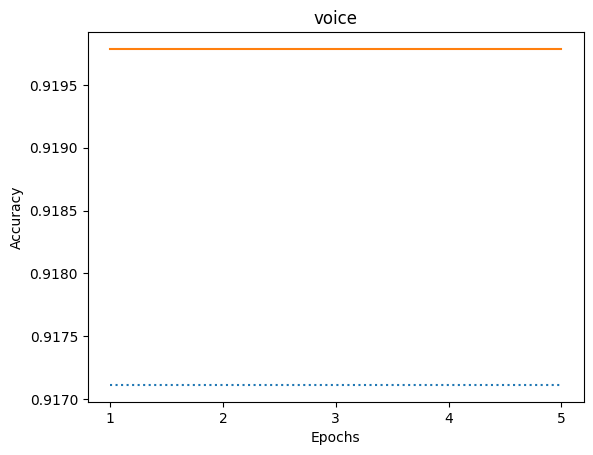

In [28]:
for i in class_map:
    plt.plot(accuracies_over_time[i], linestyle='dotted')
    plt.plot(ctrl_accuracies[i])
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(accuracies_over_time[i])), np.arange(1, len(accuracies_over_time[i])+1))
    plt.ylabel("Accuracy")
    plt.title(i)
    plt.show()

In [29]:
# Plot average accuracy across instruments
partial = []
control = []

for n in range(EPOCHS):
    t = [accuracies_over_time[i][n] for i in accuracies_over_time]   # isolates the indices
    b = [ctrl_accuracies[i][n] for i in ctrl_accuracies]   # isolates the indices
    partial.append(np.average(t))
    control.append(np.average(b))

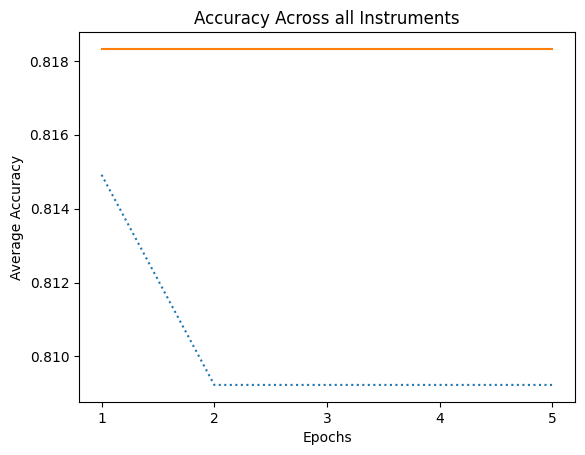

In [30]:
plt.plot(partial, linestyle='dotted')
plt.plot(control)
plt.xlabel("Epochs")
plt.xticks(np.arange(len(accuracies_over_time[i])), np.arange(1, len(accuracies_over_time[i])+1))
plt.ylabel("Average Accuracy")
plt.title("Accuracy Across all Instruments")
plt.show()